# Imports

In [26]:
import pandas as pd
import numpy as np
import bz2
import json
import pickle

from extraction_helpers import *
import os


In [ ]:
# filename = open("extracted_data\output_2020 speakers_False keywords_['hurricane', 'climate change'].pickle", "rb")
# df = pickle.load(filename)

In [2]:
# Load pickle file

filename = os.listdir('./extracted_data')[0]
print("Considered file : " + "'" + filename +"'")

filename = open("extracted_data/{}".format(filename), "rb")
dict_df = pickle.load(filename)

Considered file : 'output_2019 speakers_False keywords_['hurricane', 'climate change'].pickle'


In [ ]:
# print("Speakers : " + str(list(dict_df.keys())))
# print("Keywords : " + str(list(dict_df[list(dict_df.keys())[0]].keys())))

In [3]:
dict_df

{'hurricane':                 quoteID                                          quotation  \
 1     2019-02-27-008811  As governor of Florida, I saw firsthand the de...   
 2     2019-09-02-052055  The core of extremely dangerous Hurricane Dori...   
 3     2019-05-09-131870  Why go to school if we won't have a future? Wh...   
 4     2019-12-30-067171  Will 2020 give Florida a break in hurricane se...   
 5     2019-08-29-106120  We could see a weakening hurricane staying inl...   
 ...                 ...                                                ...   
 5195  2019-02-20-078267  Probably almost half our land was covered by w...   
 5196  2019-02-15-112277  We are used to hurricanes, but nothing like wh...   
 5197  2019-08-30-005357  And no, I don't wish anyone, anywhere, the hor...   
 5198  2019-10-13-041713  The bad news is we are not at all on the right...   
 5199  2019-09-06-017079  Dorian should remain a powerful hurricane as i...   
 
                    speaker          

# Treat data

In [4]:
# In each date, remove the info about hours, minutes and seconds
# This facilitates aggregating data for each day

for keyword in dict_df:
    for index, row in dict_df[keyword].iterrows():
        dict_df[keyword]['date'][index] = pd.to_datetime(str(row['date'])[:10])


C:\Users\clnma\AppData\Local\Temp/ipykernel_12688/1242928348.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_df[keyword]['date'][index] = pd.to_datetime(str(row['date'])[:10])


In [5]:
# Sort the values in ascending chronological order

for keyword in dict_df:
    dict_df[keyword] = dict_df[keyword].sort_values('date', ascending=True)


In [6]:
dict_count_occurences = {}
for keyword in dict_df:
    dict_count_occurences[keyword] = dict_df[keyword]['date'].value_counts(sort=False)

In [7]:
for keyword in dict_count_occurences:
    print(dict_count_occurences[keyword].shape)

(358,)
(365,)


In [15]:
for keyword in dict_count_occurences:
    for key in dict_count_occurences[keyword].keys():
        for keyword2 in dict_count_occurences:
            if key not in dict_count_occurences[keyword2].keys():
                dict_count_occurences[keyword2][key] = 0

for keyword in dict_count_occurences:
    dict_count_occurences[keyword].sort_index(inplace = True)

            

In [16]:
for keyword in dict_count_occurences:
    print(dict_count_occurences[keyword].shape)

(365,)
(365,)


# Plots

In [17]:
dict_count_occurences['hurricane']

2019-01-01     8
2019-01-02     4
2019-01-03    12
2019-01-04    11
2019-01-05     1
              ..
2019-12-27     3
2019-12-28     2
2019-12-29     2
2019-12-30     2
2019-12-31     2
Name: date, Length: 365, dtype: int64

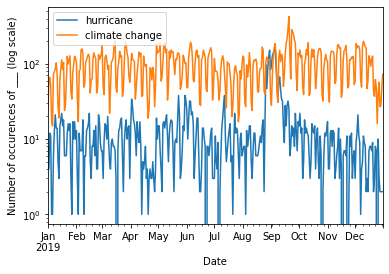

In [19]:
for keyword in dict_df:
    ax = dict_count_occurences[keyword].plot(logy = True)
ax.set_xlabel("Date")
ax.set_ylabel("Number of occurences of ___ (log scale)")
ax.legend([keyword for keyword in dict_df], loc = 'upper left')

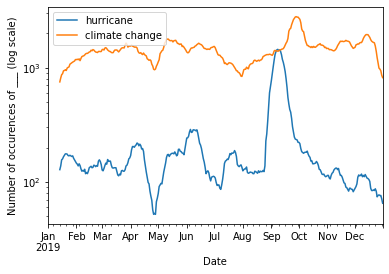

In [20]:
for keyword in dict_df:
    ax_roll = dict_count_occurences[keyword].rolling(14).sum().plot(logy = True)
ax_roll.set_xlabel("Date")
ax_roll.set_ylabel("Number of occurences of ___ (log scale)")
ax_roll.legend([keyword for keyword in dict_df], loc = 'upper left')

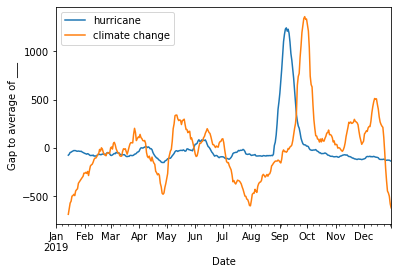

In [21]:
for keyword in dict_df:
    ax_roll = (dict_count_occurences[keyword].rolling(14).sum() - dict_count_occurences[keyword].rolling(14).sum().mean()).plot()
ax_roll.set_xlabel("Date")
ax_roll.set_ylabel("Gap to average of ___")
# ax_roll.set_ylim([300, 1500])
ax_roll.legend([keyword for keyword in dict_df], loc = 'upper left')

# Correlations

In [22]:
from statsmodels.tsa.stattools import ccf

In [31]:
hurr_n = dict_count_occurences['hurricane']
clim_n = dict_count_occurences['climate change']

<AxesSubplot:>

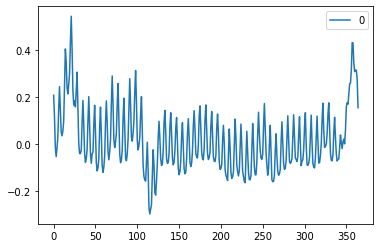

In [40]:
output_ccf = ccf(clim_n, hurr_n)
pd.DataFrame(output_ccf).plot()

<AxesSubplot:>

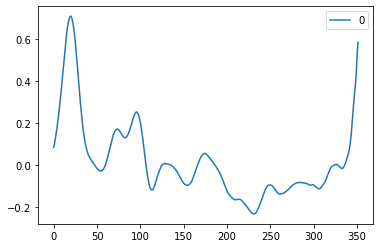

In [54]:
hurr_r = dict_count_occurences['hurricane'].rolling(14).sum()[13:]
clim_r = dict_count_occurences['climate change'].rolling(14).sum()[13:]

output_ccf = pd.DataFrame(ccf(clim_r, hurr_r))
output_ccf.plot()

In [ ]:
# ymax = output_ccf.max()
# xpos = np.where(y == ymax)
# xmax = x[xpos]